# Loading data & Defining Model

In [1]:
import numpy as np
from tensorflow.keras.datasets import mnist
import matplotlib.pyplot as plt
import scipy
import pandas as pd
from scipy import stats

## Exercise 1: Write a clustering algorithm based on the multinomial mixture model and apply it to the MNIST data.

We use a simple multinomial mixture model in which we assign the images to clusters based on the amount of active pixels. To make our data binary, we will threshold the pixel values at 0.5 (after normalization). This means that all pixels with a value greater than 0.5 will be considered active (i.e., 1), and all pixels with a value less than or equal to 0.5 will be considered inactive (i.e., 0). This algorithm is unsupervised, so it clusters the data without using the actual MNIST labels.

In [ ]:
# load data; ignore labels
(x_train, _), (x_test, _) = mnist.load_data()

# flatten image into 1D vector and normalize pixel values [0,255] -> [0,1]
x_train = x_train.reshape(-1, 28*28) / 255.0
x_test = x_test.reshape(-1, 28*28) / 255.0

# binarize the data: values greater than 0.5 become 1, else 0
x_train = (x_train > 0.5).astype(int)
x_test = (x_test > 0.5).astype(int)

In [ ]:
def update_clusters(x, cluster_assignments, n_clusters, n_samples, n_features):
    # initalize
    cluster_counts = np.zeros((n_clusters, n_features))
    cluster_totals = np.zeros(n_clusters)

    # count number of pixels activated for each cluster
    for i in range(n_samples):
        cluster = cluster_assignments[i]
        cluster_counts[cluster] += x[i]
        cluster_totals[cluster] += 1

    # compute for each sample the likelihood of it belonging to that cluster
    for i in range(n_samples):
        likelihoods = np.zeros(n_clusters)
        for c in range(n_clusters):
            # compute probability of a pixel being active in a cluster
            probs = (cluster_counts[c] + 1) / (cluster_totals[c] + 2)

            # compute likelihood of current sample under cluster c
            likelihoods[c] = np.sum(np.log(probs) * x[i] + np.log(1 - probs) * (1 - x[i]))

        # assign sample to highest likelihood
        cluster_assignments[i] = np.argmax(likelihoods)

    return cluster_assignments

def display_cluster_images(x, cluster_assignments, n_clusters):
    fig, axes = plt.subplots(1, n_clusters, figsize=(20, 20))

    for c in range(n_clusters):
        # get all samples in the cluster
        cluster_samples = x[cluster_assignments == c]

        # get mean image for that cluster
        mean_image = np.mean(cluster_samples, axis=0)

        #plot it
        ax = axes[c]
        ax.imshow(mean_image.reshape(28, 28), cmap='gray')
        ax.axis('off')
        ax.set_title(f'Cluster {c}')

    plt.show()

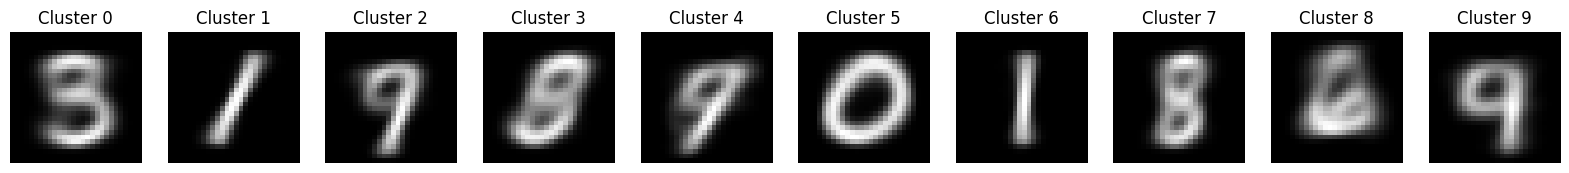

In [ ]:
# parameters
n_clusters = 10
n_features = 28*28
n_samples = x_train.shape[0]
n_iterations = 30

# randomly initialize clusters
cluster_assignments = np.random.randint(n_clusters, size=n_samples)

#loop over the clustering algorithm until it stabilizes
prev_assignments = np.zeros(n_samples)
for iteration in range(n_iterations):
    cluster_assignments = update_clusters(x_train, cluster_assignments, n_clusters, n_samples, n_features)

    # early stopping mechanism
    if np.array_equal(cluster_assignments, prev_assignments):
        break
    prev_assignments = cluster_assignments.copy()

# plot the mean image for each cluster
display_cluster_images(x_train, cluster_assignments, n_clusters)

We can see that the multinomial mixture model does not work that well. The digits 2,4,5 were not learned // clustered at all. The digits 1, 8 and 9 were all seperated into 2 or 3 slightly different clusters, though they have the same label in reality. These different clusters have a slight skew applied to them (e.g. $8$ vs $\mathit{8}$), which the cluster algorithm can't differentiate between (e.g. no skew-shift invariance) The clusters 3 and 6 are still recognizable, though they are somewhat blurred.

# Exercise 2
Consider the one dimensional Gaussian mixture model <br>
$p(x, k) = \pi_k \left( \frac{1}{\sqrt{2\pi\sigma_k^2}} \right) \exp \left( - \frac{(x - a_k)^2}{2\sigma_k^2} \right)$  with observable data $x_\mu,\mu = 1, \ldots, N$ and discrete latent variable $k = 1, \ldots, K$. <br>
Derive an EM algorithm to estimate the parameters $\pi_k,a_k,\sigma^2_k,k = 1, \ldots, K$ from the data. Proceed with the following steps.

### a) Give an expression for the responsabilities $r^k_μ$ that result from the E step.

The responsibility is defined as the normalized posterior probabilities of the latent variable $k$ given the data:
\begin{equation}
r^k_\mu = \frac{\text{Probability that } x_\mu \text{ belongs to component } k}{\text{Total probability that } x_\mu \text{ was generated by any component}} =\frac{p(k | x_\mu, \theta)}{p(x_\mu | \theta)}
\end{equation}

where $\theta$ represents all the parameters we want to estimate: \( \pi_k, a_k, \sigma_k^2 \). The total likelihood is given by:

\begin{equation}
p(x_\mu | \theta) = \sum_{k=1}^K \pi_k \left( \frac{1}{\sqrt{2\pi\sigma_k^2}} \right) \exp \left( - \frac{(x_\mu - a_k)^2}{2\sigma_k^2} \right)
\end{equation}

with $x_\mu$ a data point. $\pi_k$ the mixing coefficient of the $k^{th}$ Gaussian. $a_k$ and $\sigma_k^2$ are the mean and variance of the $k^{th}$ Gaussian. The responsibility is then defined as:

\begin{equation}
r^k_\mu = \frac{\pi_k \left( \frac{1}{\sqrt{2\pi\sigma_k^2}} \right) \exp \left( - \frac{(x_\mu - a_k)^2}{2\sigma_k^2} \right)}{\sum_{j=1}^K \pi_j \left( \frac{1}{\sqrt{2\pi\sigma_j^2}} \right) \exp \left( - \frac{(x_\mu - a_j)^2}{2\sigma_j^2} \right)}
\end{equation}

$r^k_\mu$ tells us the "responsibility" of Gaussian $k$ for explaining the observation $x_\mu$. The higher $r^k_\mu$ is, the more likely it is that $x_\mu$ was generated by Gaussian $k$.

### b) Give an expression for the variational bound $Q(\theta, q^*)$ in terms of the responsabilities.


\begin{equation*}
    \ln p(x_\mu, k | \theta) = \ln \pi_k + \ln \left( \frac{1}{\sqrt{2\pi\sigma_k^2}} \right) - \frac{(x_\mu - a_k)^2}{2\sigma_k^2}
\end{equation*}

The variational bound $Q$ is the expected value of this complete-data log likelihood:

\begin{equation*}
    Q(\theta, q^*) = \sum_{\mu=1}^N \sum_{k=1}^K r^k_\mu \ln p(x_\mu, k | \theta)
\end{equation*}

Substitute in our expression for the complete-data log likelihood:

\begin{equation*}
Q(\theta, q^*) = \sum_{\mu=1}^N \sum_{k=1}^K r^k_\mu \left( \ln \pi_k + \ln \left( \frac{1}{\sqrt{2\pi\sigma_k^2}} \right) - \frac{(x_\mu - a_k)^2}{2\sigma_k^2} \right)
\end{equation*}

This provides a lower bound for the actual likelihood that we want to maximize. In the E-step, we compute the responsibilities, and in the M-step, we maximize the lower bound $Q$ with respect to the parameters $\theta$.

### c) Show that the M-step can be solved in close form and yields new values of $\pi_k,a_k,\sigma^2_k,k = 1, \ldots, K$ in terms of the responsabilities and the data. Check that your final result agrees with the multi-dimensional case presented in the slides.

### M-step for $a_k$

To find the value of $ a_k $ that maximizes $ Q $, differentiate $ Q $ with respect to $ a_k $ and set it to zero:

\begin{equation}
 \frac{\partial}{\partial a_k} Q = \sum_{\mu=1}^N r^k_\mu \frac{(x_\mu - a_k)}{\sigma_k^2} = 0
\end{equation}

From this:
\begin{equation}
 a_k \sum_{\mu=1}^N r^k_\mu = \sum_{\mu=1}^N r^k_\mu x_\mu
\end{equation}

The new value for $ a_k $ is:
\begin{equation}
 a_k = \frac{\sum_{\mu=1}^N r^k_\mu x_\mu}{\sum_{\mu=1}^N r^k_\mu}
\end{equation}

### M-step for $\sigma_k$
\begin{equation}
 \frac{\partial}{\partial \sigma_k^2} Q = \sum_{\mu=1}^N r^k_\mu \left( \frac{1}{2\sigma_k^2} - \frac{(x_\mu - a_k)^2}{2(\sigma_k^2)^2} \right) = 0
\end{equation}
From this:
\begin{equation}
 \sigma_k^2 = \frac{\sum_{\mu=1}^N r^k_\mu (x_\mu - a_k)^2}{\sum_{\mu=1}^N r^k_\mu}
\end{equation}

### M-step for $\pi_k$
We introduce a Lagrangian multiplier using our constraint $\sum_{k=1}^K \pi_k = 1$ :

\begin{equation}
L = Q(\theta, q^*) + \lambda \left( 1 - \sum_{k=1}^K \pi_k \right)
\end{equation}

We maximize this Lagrangian w.r.t $ \pi_k $:

\begin{equation}
\frac{\partial L}{\partial \pi_k} = \sum_{\mu=1}^N r^k_\mu \frac{1}{\pi_k} - \lambda = 0
\end{equation}

From this, we get:

\begin{equation}
    \lambda \pi_k = \sum_{\mu=1}^N r^k_\mu
\end{equation}


Sum this expression over all clusters:

\begin{equation*}
\sum_{k=1}^K \lambda \pi_k = \sum_{k=1}^K \sum_{\mu=1}^N r^k_\mu
\end{equation*}

Given our constraint $\sum_{k=1}^K \pi_k = 1$, this becomes:

\begin{equation*}
\lambda = \sum_{k=1}^K \sum_{\mu=1}^N r^k_\mu
\end{equation*}

The term on the right is the sum of responsibilities across all clusters and all data points, which gives the total number of data points $N$:

\begin{equation*}
\lambda = N
\end{equation*}

Substitute this into the equation for $\lambda \pi_k$

\begin{equation*}
N \pi_k = \sum_{\mu=1}^N r^k_\mu
\end{equation*}
\begin{equation*}
\pi_k = \frac{\sum_{\mu=1}^N r^k_\mu}{N}
\end{equation*}




## Q3. Reproduce Murphy fig. 11.11 using the EM algorithm

http://noiselab.ucsd.edu/ECE228/Murphy_Machine_Learning.pdf <br>
https://github.com/probml/pmtk3/blob/master/demos/mixGaussDemoFaithful.m <br>
https://www.stat.cmu.edu/~larry/all-of-statistics/=data/faithful.dat

In [3]:
data = pd.read_csv("/content/Old Faithful Geyser.txt", skiprows=21, delim_whitespace=True)
data_standard = pd.DataFrame({"eruptions":[],"waiting":[]})
data_standard["eruptions"] = (data['eruptions'] - data['eruptions'].mean()) / data['eruptions'].std()
data_standard["waiting"] = (data['waiting'] - data['waiting'].mean()) / data['waiting'].std()


   eruptions   waiting
1   0.098318  0.596025
2  -1.478733 -1.242890
3  -0.135612  0.228242
4  -1.055558 -0.654437
5   0.915755  1.037364


In [27]:
def EM(data, prior1, prior2, iterations):

    N = len(data)
    x = data.values
    prob_x = [prior1.pdf(x),prior2.pdf(x)]
    pk = np.full(2,0.5)
    rk = np.zeros((2,N))
    denom = np.zeros(N)
    muk = []
    covk = []
    color1 = []
    color2 = []
    for i in range(iterations):
        denom = pk[0]*prob_x[0]+pk[1]*prob_x[1]

        rk[0] = pk[0]*prob_x[0]/denom
        rk[1] = pk[1]*prob_x[1]/denom

        color1.append(rk[0].copy())
        color2.append(rk[1].copy())

        pk = np.sum(rk,axis=1)/N

        mean_class_1 = np.sum([rk[0,i]*x[i] for i in range(N)],0)/np.sum(rk[0])
        mean_class_2 = np.sum([rk[1,i]*x[i] for i in range(N)],0)/np.sum(rk[1])

        muk.append([mean_class_1.tolist(),mean_class_2.tolist()])

        cov_1 = np.sum([rk[0, i] * np.outer(x[i] - mean_class_1, x[i] - mean_class_1) for i in range(N)],
                       axis=0) / np.sum(rk[0])
        cov_2 = np.sum([rk[1, i] * np.outer(x[i] - mean_class_2, x[i] - mean_class_2) for i in range(N)],
                       axis=0) / np.sum(rk[1])

        covk.append([cov_1,cov_2])

        newpdf1 = stats.multivariate_normal(mean_class_1, cov_1)
        newpdf2 = stats.multivariate_normal(mean_class_2, cov_2)

        prob_x = [newpdf1.pdf(x),newpdf2.pdf(x)]

    return [newpdf1,newpdf2], muk, covk, color1, color2

In [28]:
np.random.seed(402)
prior_mean_1 = sum([-1.5,1.5]+ 0.8*np.random.rand(1,2))
prior_cov_1 = [[1,0],[0,1]]
prior_1 = stats.multivariate_normal(prior_mean_1, prior_cov_1)

prior_mean_2 = sum([1.5,-1.5]+ 0.8*np.random.rand(1,2))
prior_cov_2 = [[1,0],[0,1]]
prior_2 = stats.multivariate_normal(prior_mean_2, prior_cov_2)

finalclusters, means, covariances, color1, color2 = EM(data_standard, prior_1, prior_2, 16)

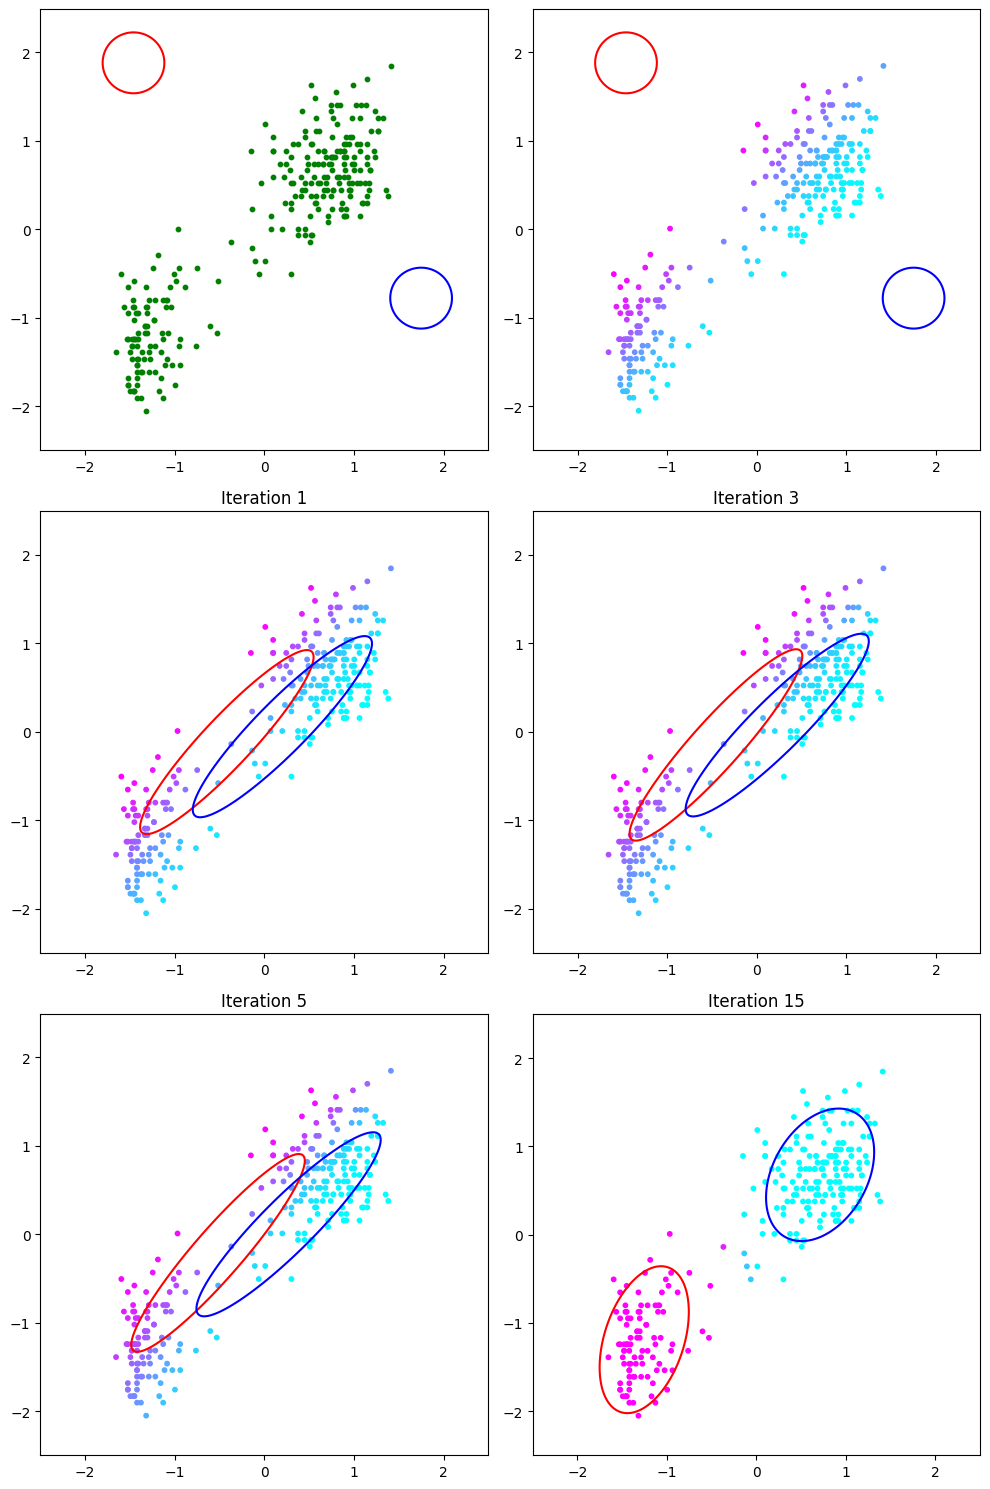

In [29]:
# Create a figure and a 3x2 grid of subplots
fig, axs = plt.subplots(3, 2, figsize=(10, 15))
x, y = np.mgrid[-2.5:2.5:.01, -2.5:2.5:.01]
pos = np.dstack((x, y))

# You can now plot on each individual subplot

# plot the
axs[0, 0].contour(x, y, prior_1.pdf(pos), [0.15], colors = "r")
axs[0, 0].contour(x, y, prior_2.pdf(pos), [0.15], colors = "b")
axs[0, 0].scatter(data_standard["eruptions"], data_standard["waiting"], s =10, c="g")
# axs[0, 0].set_title('Subplot 1')
plt.xlim([-2.5,2.5])
plt.ylim([-2.5,2.5])

#plot with change in color
axs[0, 1].contour(x, y, prior_1.pdf(pos), [0.15], colors = "r")
axs[0, 1].contour(x, y, prior_2.pdf(pos), [0.15], colors = "b")
colors0 = color1[0]-color2[0]
axs[0, 1].scatter(data_standard["eruptions"], data_standard["waiting"], s =10, c=colors0
                  ,cmap = "cool")
# axs[0, 1].set_title('Subplot 1')

# plot iteration 1:
pdf1 = stats.multivariate_normal(means[0][0], covariances[0][0])
pdf2 = stats.multivariate_normal(means[0][1], covariances[0][1])
axs[1, 0].contour(x, y, pdf1.pdf(pos), [0.25], colors = "r")
axs[1, 0].contour(x, y, pdf2.pdf(pos), [0.25], colors = "b")
colors1 = color1[1]-color2[1]
axs[1, 0].scatter(data_standard["eruptions"], data_standard["waiting"], s =10, c=colors1
                  ,cmap = "cool")
axs[1, 0].set_title('Iteration 1')

# plot iteration 3
pdf1 = stats.multivariate_normal(means[2][0], covariances[2][0])
pdf2 = stats.multivariate_normal(means[2][1], covariances[2][1])
axs[1, 1].contour(x, y, pdf1.pdf(pos), [0.25], colors = "r")
axs[1, 1].contour(x, y, pdf2.pdf(pos), [0.25], colors = "b")
colors3 = color1[3]-color2[3]
axs[1, 1].scatter(data_standard["eruptions"], data_standard["waiting"], s =10, c=colors3
                  ,cmap = "cool")
axs[1, 1].set_title('Iteration 3')

# plot iteration 5
pdf1 = stats.multivariate_normal(means[4][0], covariances[4][0])
pdf2 = stats.multivariate_normal(means[4][1], covariances[4][1])
axs[2, 0].contour(x, y, pdf1.pdf(pos), [0.25], colors = "r")
axs[2, 0].contour(x, y, pdf2.pdf(pos), [0.25], colors = "b")
colors5 = color1[5]-color2[5]
axs[2, 0].scatter(data_standard["eruptions"], data_standard["waiting"], s =10, c=colors5
                  ,cmap = "cool")
axs[2, 0].set_title('Iteration 5')

# plot iteration 15
pdf1 = stats.multivariate_normal(means[15][0], covariances[15][0])
pdf2 = stats.multivariate_normal(means[15][1], covariances[15][1])
axs[2, 1].contour(x, y, pdf1.pdf(pos), [0.25], colors = "r")
axs[2, 1].contour(x, y, pdf2.pdf(pos), [0.25], colors = "b")
colors15 = color1[15]-color2[15]
axs[2, 1].scatter(data_standard["eruptions"], data_standard["waiting"], s =10, c=colors15
                  ,cmap = "cool")
axs[2, 1].set_title('Iteration 15')


# Adjust the layout to prevent overlap
plt.tight_layout()

# Display the figure
plt.show()